In [2]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from google.colab import drive
import os
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376418 sha256=8bc59c64af5840d806becc9e5d06470a68df10fe2d539f77def5d6eeff599629
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
Mounted at /content/drive


In [3]:
class QNet(nn.Module):
    def __init__(self) -> None:
        super(QNet, self).__init__()
        self.I = nn.Linear(8, 128)
        self.H = nn.Linear(128, 128)
        self.O = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.I(x))
        x = F.relu(self.H(x))
        return self.O(x)

class TargetQNet(nn.Module):
    def __init__(self) -> None:
        super(TargetQNet, self).__init__()
        self.I = nn.Linear(8, 128)
        self.H = nn.Linear(128, 128)
        self.O = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.I(x))
        x = F.relu(self.H(x))
        return self.O(x)

def ComputeLoss(experiences, gamma, QNet, TargetQNet):
    states = torch.FloatTensor([exp.state for exp in experiences])
    actions = torch.LongTensor([[exp.action] for exp in experiences])
    rewards = torch.FloatTensor([[exp.reward] for exp in experiences])
    next_states = torch.FloatTensor([exp.next_state for exp in experiences])
    terminateds = torch.FloatTensor([[1 - exp.terminated] for exp in experiences])

    next_q_values = TargetQNet(next_states)
    max_next_q_values = torch.max(next_q_values, dim=1, keepdim=True)[0]

    target_q_values = rewards + (gamma * max_next_q_values * terminateds)

    q_values = QNet(states)
    q_values = q_values.gather(1, actions)

    loss = F.smooth_l1_loss(q_values, target_q_values.detach())
    return loss

def AgentLearn(experiences, gamma, QNet, TargetQNet, optimizer):
    loss = ComputeLoss(experiences, gamma, QNet, TargetQNet)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'terminated', 'truncated'))

In [4]:
env = gym.make("LunarLander-v3")
QNet = QNet()
TargetQNet = TargetQNet()
optimizer = optim.Adam(QNet.parameters(), lr=0.001)
gamma = 0.99

max_episodes = 10000
max_num_timesteps = 2000
num_p_av = 100
epsilon = 1.00
batch_size = 32
memory_buffer = deque(maxlen=10000)
TargetQNet.load_state_dict(QNet.state_dict())
total_point_history = []

for i in range(max_episodes):
    state, _ = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(QNet(state_tensor)).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_points += reward

        memory_buffer.append(Experience(state, action, reward, next_state, terminated, truncated))

        if len(memory_buffer) >= batch_size:
            experiences = random.sample(list(memory_buffer), batch_size)
            AgentLearn(experiences, gamma, QNet, TargetQNet, optimizer)

        state = next_state

        if terminated or truncated:
            break

    total_point_history.append(total_points)
    epsilon = max(0.01, epsilon * 0.995)

    if i % 10 == 0:
        TargetQNet.load_state_dict(QNet.state_dict())

    av_latest_points = np.mean(total_point_history[-num_p_av:])
    print(f"\rEpisode {i+1} | Latest average: {av_latest_points:.2f}", end="")
    if (i + 1) % num_p_av == 0:
        print(f"\nCompleted {i+1} episodes | Average over last {num_p_av}: {av_latest_points:.2f}")

    if av_latest_points >= 200.0:
        print(f"\nEnvironment solved in {i+1} episodes!")
        torch.save(QNet.state_dict(), 'lunar_lander_model.pth')
        break

<ipython-input-3-a3237393710b>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([exp.state for exp in experiences])


Episode 100 | Latest average: -111.20
Completed 100 episodes | Average over last 100: -111.20
Episode 200 | Latest average: -33.06
Completed 200 episodes | Average over last 100: -33.06
Episode 300 | Latest average: -18.76
Completed 300 episodes | Average over last 100: -18.76
Episode 400 | Latest average: 57.91
Completed 400 episodes | Average over last 100: 57.91
Episode 500 | Latest average: 138.35
Completed 500 episodes | Average over last 100: 138.35
Episode 577 | Latest average: 200.31
Environment solved in 577 episodes!


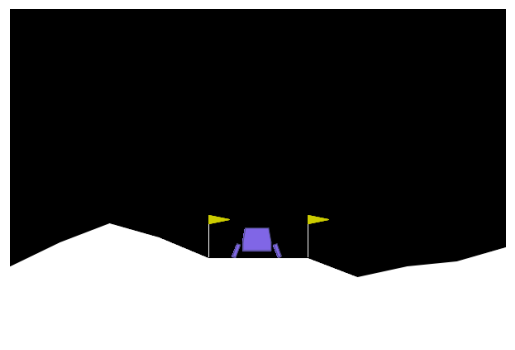

Episode completed with reward: 251.33684389655204


In [6]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
tot_reward = 0

videos_dir = "/content/drive/MyDrive/LunarLander_Videos"
if not os.path.exists(videos_dir):
    os.makedirs(videos_dir)

curr_state, _ = env.reset()
env = gym.wrappers.RecordVideo(env, videos_dir, episode_trigger=lambda episode_id: True, name_prefix="Trained Lander")

plt.ion()
fig, ax = plt.subplots()
im = ax.imshow(env.render())
plt.axis("off")

for t in range(max_num_timesteps):
    rgb_array = env.render()
    im.set_data(rgb_array)
    curr_state_tensor = torch.FloatTensor(curr_state).unsqueeze(0)
    action = torch.argmax(QNet(curr_state_tensor)).item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    tot_reward += reward
    curr_state = next_state
    if terminated or truncated:
        break

rgb_array = env.render()
im.set_data(rgb_array)
plt.ioff()
plt.show()
env.close()
print(f"Episode completed with reward: {tot_reward}")